# import needed packages

In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error
#from sklearn.pipeline import make_pipeline

# from sklearn.cross_validation import *
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn import svm

from sklearn.metrics import mean_absolute_error as mae

import matplotlib.pyplot as plt
%matplotlib inline

# read in data and seperate to train and test

In [8]:
# read in and prepare X_train, y_train and X_test data
X_train=pd.read_csv('MLProjectData.csv')
X_test=pd.read_csv('testData.csv',index_col=0)

y_train = X_train['target']
X_train.drop('target',axis=1,inplace=True)

# label to split the training and testing
X_train['train']=True
X_test['train']=False

temp=pd.get_dummies(X_train.append(X_test,sort=False))
X_train=temp[temp['train']==True].drop('train',axis=1)
X_test=temp[temp['train']==False].drop('train',axis=1)

## prepare validation data

In [9]:
X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

# Visualize the target

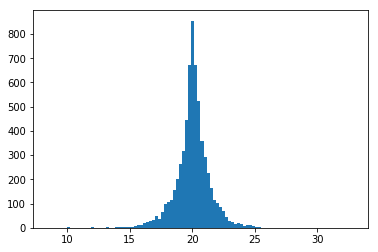

In [37]:
plt.hist(y_train,bins=100);

In [27]:
y_train.quantile(q=0.05)

17.744500000000002

In [28]:
y_train.quantile(q=0.95)

22.24

In [ ]:
np.random.rand()

# Benchmark for median and mean

In [20]:
y_mean=np.repeat(y_train.mean(), len(y_train))
y_median=np.repeat(y_train.median(), len(y_train))
print('Benchmark R2 of mean:',r2_score(y_train, y_mean)) 
print('Benchmark R2 of median:',r2_score(y_train, y_median)) 
print('Benchmark mae of median:',mae(y_train, y_median)) 

Benchmark R2 of mean: 1.1102230246251565e-16
Benchmark R2 of median: -0.0003503183503301699
Benchmark mae of median: 0.9563565006299212


# SVR

## Simple SVR

In [39]:
svr = svm.SVR(gamma='auto')
svr.fit(X_t, y_t) 

print('Training R2:',r2_score(y_t, svr.predict(X_t))) 
print('Validation R2:',r2_score(y_v, svr.predict(X_v))) 

Training R2: 0.5895125257755935
Validation R2: -0.0029139064853986874


In [42]:
svr.get_params

<bound method BaseEstimator.get_params of SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)>

## Grid Search

In [ ]:
svr_grid = svm.SVR()

params_svr = {'C': [1,3,3.5,4], 
              'gamma': [2,1.5,1,0.8, 0.5],
              'kernel': ['rbf'],
              'degree':[2,3,4]}

grid_svr = GridSearchCV(svr_grid, params_svr,cv=5)
grid_svr.fit(X_t, y_t)

# Print the r2 score
print('Training R2:',r2_score(y_t, grid_svr.best_estimator_.predict(X_t)))
print('Training R2:',r2_score(y_v, grid_svr.best_estimator_.predict(X_v))) 

# best model 1

# SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
#   kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

# SVR(C=3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
#   kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

# SVR(C=3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.9,
#   kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
# Training R2: 0.9090573555403174
# Training R2: -0.0013610386571483168

In [53]:
grid_svr.best_estimator_

SVR(C=3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.9,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [54]:
grid_svr

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 3, 5, 8, 12], 'gamma': [0.9, 0.5, 0.1, 0.01, 0.001], 'kernel': ['rbf'], 'degree': [3, 4, 5, 8, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [59]:
print(r2_score(y_t, grid_svr.best_estimator_.predict(X_t))) 

0.9090573555403174


## check model

In [10]:
svr_validate = svm.SVR(C=3,degree=3,gamma=0.9,kernel='rbf')

In [11]:
svr_validate.fit(X_t,y_t)

SVR(C=3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.9,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [12]:
mse(y_v,svr_validate.predict(X_v))

0.950922090903681

In [23]:
print(r2_score(y_t, svr_validate.predict(X_t))) 
print(r2_score(y_v, svr_validate.predict(X_v))) 
print(r2_score(y_train, svr_validate.predict(X_train)))
print(mae(y_v, svr_validate.predict(X_v))) 

0.9090573555403174
-0.0013610386571483168
0.6447989962076948
0.950922090903681


# xgboost

In [15]:
xgr = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
# xgr.fit(X_train, y_train)

# A parameter grid for XGBoost
# params = {'min_child_weight':[4,5],
#           'gamma':[i/10.0 for i in range(3,6)],
#           'subsample':[i/10.0 for i in range(6,11)],
#           'colsample_bytree':[i/10.0 for i in range(6,11)],
#           'max_depth': [2,3,4],
#           'gpu_id':[0],
#           'max_bin':[16],
#           'tree_method':['gpu_hist'],
#          'cv':[3]}

params = {'gpu_id':[0],
          'tree_method':['gpu_exact'],
          'n_estimators':[10,30,50,100,300,500,1000,2000,3000],
          'learning_rate':[0.001,0.01,0.03, 0.05,0.08, 0.1,0.3,0.5,0.7],
          'max_depth':[2,3,4]
         }


# Initialize XGB and GridSearch
xgb = XGBRegressor(nthread=-1) 

grid = GridSearchCV(xgb, params)
grid.fit(X_train, y_train)

# Print the r2 score
print(r2_score(y_train, grid.best_estimator_.predict(X_train))) 

# Save the file
# y_test = grid.best_estimator_.predict(x_test)
# results_df = pd.DataFrame(data={'y':y_test}) 
# ids = test_df["ID"]
# joined = pd.DataFrame(ids).join(results_df)
# joined.to_csv("mercedes.csv", index=False)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


ValueError: Invalid parameter gpu_id for estimator XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1). Check the list of available parameters with `estimator.get_params().keys()`.

In [43]:
print(r2_score(y_train, grid.best_estimator_.predict(X_train))) 

0.10545506348483091


In [45]:
grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, gpu_id=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
       nthread=-1, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, tree_method='gpu_exact')

Best Estimator 1

r2_score: 0.10044651984945663

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, cv=3, gamma=0, gpu_id=0, importance_type='gain',
       learning_rate=0.05, max_bin=16, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=-1, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, tree_method='gpu_exact')
       

{'cv': 3,
 'gpu_id': 0,
 'learning_rate': 0.05,
 'max_bin': 16,
 'max_depth': 2,
 'n_estimators': 100,
 'tree_method': 'gpu_exact'}

Best Estimator 2

0.10545506348483091

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, gpu_id=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
       nthread=-1, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, tree_method='gpu_exact')
       
       
{'gpu_id': 0,
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 50,
 'tree_method': 'gpu_exact'}

In [46]:
grid.best_params_

{'gpu_id': 0,
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 50,
 'tree_method': 'gpu_exact'}

In [51]:
xgr = XGBRegressor(learning_rate=0.1, n_estimators=50, max_depth=2)

xgr.fit(X_t,y_t)
print('Training R2:',r2_score(y_t, xgr.predict(X_t)))
print('Validation R2:',r2_score(y_v, xgr.predict(X_v))) 

Training R2: 0.12949338365454377
Validation R2: -0.031244767050766953


## validate

In [24]:
xgr = XGBRegressor(learning_rate=0.1, n_estimators=50, max_depth=2)

xgr.fit(X_t,y_t)
print('Training R2:',r2_score(y_t, xgr.predict(X_t)))
print('Validation R2:',r2_score(y_v, xgr.predict(X_v)))
print('whole training mae:',mae(y_train, xgr.predict(X_train))) 
print('Validation mse:',mae(y_v, xgr.predict(X_v))) 

Training R2: 0.12949338365454377
Validation R2: -0.031244767050766953
whole training mae: 0.94537442813144
Validation mse: 0.9707110896939656


## important

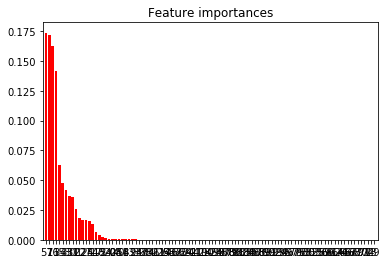

In [54]:
importances = grid.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", align="center")
plt.title("Feature importances")
#plt.bar(range(X.shape[1]), importances[indices],color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# Simple PLS

In [32]:
pls = PLSRegression(n_components=5)
pls.fit(X_train, y_train)

y_pred = pls.predict(X_train)
print('PLS R2:',r2_score(y_train, y_pred)) 

PLS R2: 0.0195066723727223


# gridsearch a PLS

In [ ]:
params_pls = {'n_components':[1,2,3,4,5,6,7,8,9,10]
             }


# Initialize XGB and GridSearch
pls = PLSRegression()

grid = GridSearchCV(xgb, params)
grid.fit(X_train, y_train)

# Print the r2 score
print(r2_score(y_train, grid.best_estimator_.predict(X_train))) 

# playground

In [56]:
# X_1, X_2, y_1, y_2 = train_test_split(X_train, y_train, test_size=0.5,random_state=42)

# y_p1 = grid.best_estimator_.predict(X_1)
# r2_score(y_1,y_p1)

# y_p2 = grid.best_estimator_.predict(X_2)
# r2_score(y_2,y_p2)